In [1]:
#!pip install lightgbm --quiet
#!pip install xgboost --quiet

In [2]:
#import kagglehub

#path = kagglehub.dataset_download("claudiodavi/superhero-set")
#print("Path to dataset files:", path)

In [3]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from preprocessing import DataProcessor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score, precision_score, roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler, power_transform, MinMaxScaler
from sklearn.feature_selection import  SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
heroes_information = pd.read_csv("/root/.cache/kagglehub/datasets/claudiodavi/superhero-set/versions/1/heroes_information.csv", index_col=0)
heroes_information = heroes_information.drop_duplicates(subset='name')
super_hero_powers = pd.read_csv("/root/.cache/kagglehub/datasets/claudiodavi/superhero-set/versions/1/super_hero_powers.csv", index_col=0)
super_hero_powers.index.name = 'name'
super_hero_powers.reset_index(inplace=True)
df = heroes_information.merge(super_hero_powers, on='name', how='inner')

In [5]:
processor = DataProcessor(df)
processor.preprocessing()
processor.normalize_min_max()
cat_heroes_information = ['Gender', 'Eye color', 'Hair color', 'Publisher']
cat_super_hero_powers = list(super_hero_powers.columns)
cat_super_hero_powers.remove('name')
cat_cols = cat_super_hero_powers + cat_heroes_information
processor.onehot_encode_columns(cat_heroes_information)
model_base = processor.df
model_base.set_index('name', inplace=True)
model_base.head(3)

,Height,Alignment,Weight,Agility,Accelerated Healing,Lantern Power Ring,Dimensional Awareness,Cold Resistance,Durability,Stealth,...,Hair color_Yellow,Hair color_black,Hair color_blond,Publisher_Dark Horse Comics,Publisher_George Lucas,Publisher_Marvel Comics,Publisher_Shueisha,Publisher_Star Trek,Publisher_Team Epic TV,Publisher_Unknown
name,,,,,,,,,,,,,,,,,,,,,
Abe Sapien,0.739130,good,0.237705,True,True,False,False,True,True,False,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Abin Sur,0.608696,good,0.442623,False,False,True,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Absorbing Man,0.782609,bad,0.704918,False,False,False,False,True,True,False,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [6]:
model_base.Alignment.value_counts()

,count
Alignment,
good,245
bad,96
neutral,10
Unknown,2


In [7]:
model_base = model_base[(model_base.Alignment == "good") | (model_base.Alignment == "bad") ]
model_base.Alignment.value_counts(normalize=True)

,proportion
Alignment,
good,0.718475
bad,0.281525


In [9]:
important_features = [
    "Energy Manipulation",
    "Hair color_Blond",
    "Hypnokinesis",
    "Weight",
    "Eye color_blue",
    "Force Fields",
    "Enhanced Senses",
    "Height",
    "Hair color_Black",
    "Power Suit",
    "Intangibility",
    "Psionic Powers",
    "Phasing",
    "Size Changing",
    "Hair color_No Hair",
    "Toxin and Disease Resistance",
    "Levitation",
    "Intelligence",
    "Longevity", 'Alignment'
]

model_base = model_base[important_features]

In [10]:
model_base['Alignment'] = model_base['Alignment'].map({'good': 1, 'bad': 0})

X = model_base.drop(['Alignment'], axis = 1)

y = model_base['Alignment']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 451, test_size= .25, stratify = y)

# Naive Bayes

In [12]:
skf = StratifiedKFold(n_splits = 5, shuffle = True)

NB = cross_validate(estimator=GaussianNB(),
                    cv=skf,
                    scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro", "roc_auc"],
                    return_estimator=True,
                    return_train_score=True,
                    verbose=2,
                    X=X_train,
                    y=y_train)

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s


In [13]:
cv_df = pd.DataFrame(NB)
cv_df

,fit_time,score_time,estimator,test_accuracy,train_accuracy,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro,test_f1_macro,train_f1_macro,test_roc_auc,train_roc_auc
0,0.009850,0.038268,GaussianNB(),0.490196,0.544118,0.675000,0.664231,0.648649,0.665919,0.488426,0.544107,0.772201,0.820855
1,0.009765,0.034372,GaussianNB(),0.509804,0.553922,0.608929,0.659743,0.617761,0.667572,0.509049,0.553653,0.743243,0.819261
2,0.005934,0.039606,GaussianNB(),0.352941,0.583333,0.514535,0.694191,0.509653,0.703708,0.343860,0.583083,0.689189,0.838628
3,0.004510,0.049889,GaussianNB(),0.568627,0.509804,0.702703,0.660131,0.694444,0.649123,0.568462,0.509380,0.853704,0.808927
4,0.005567,0.022643,GaussianNB(),0.450980,0.406863,0.620732,0.660112,0.591667,0.588435,0.445652,0.392842,0.832407,0.818534


In [14]:
teste = ['test_accuracy', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro', 'test_roc_auc']
for icol in teste:
    print('%s -> mean: %1.2f +- %1.2f' %(icol, cv_df[icol].mean(), cv_df[icol].std()))

test_accuracy -> mean: 0.47 +- 0.08
test_precision_macro -> mean: 0.62 +- 0.07
test_recall_macro -> mean: 0.61 +- 0.07
test_f1_macro -> mean: 0.47 +- 0.08
test_roc_auc -> mean: 0.78 +- 0.07


Média de acurácia de treino dos modelos: 0.5196078431372549 
 Desvio padrão de acurácia de treino dos modelos: 0.06106828040155858
Média de acurácia de teste dos modelos: 0.4745098039215686 
 Desvio padrão de acurácia de teste dos modelos: 0.07166928189214533


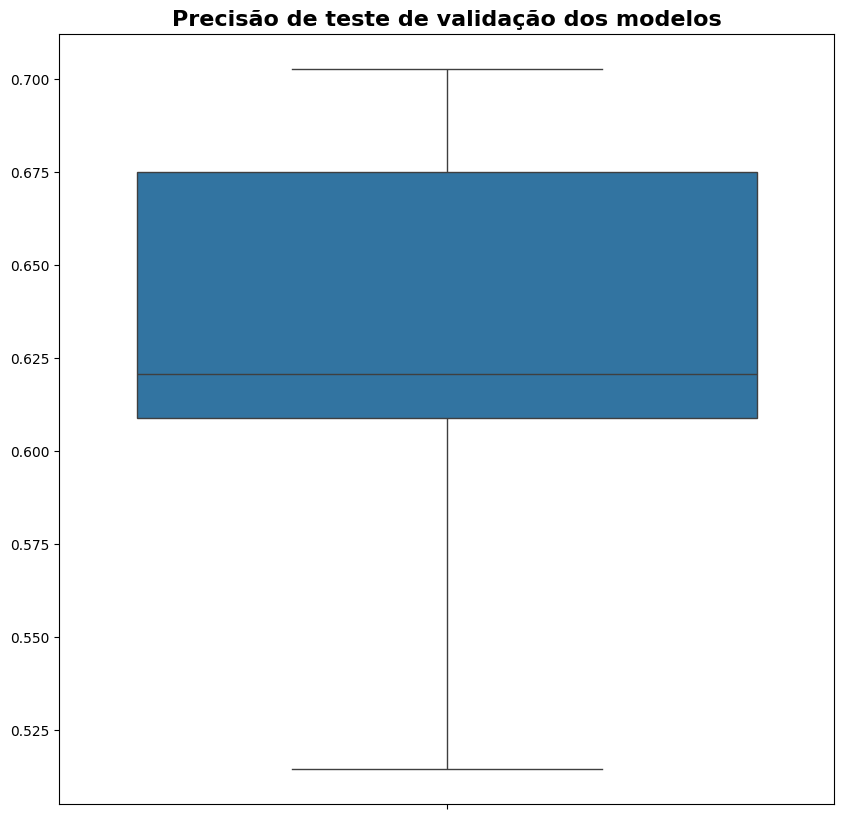

In [15]:
print("Média de acurácia de treino dos modelos:", NB["train_accuracy"].mean(), "\n", "Desvio padrão de acurácia de treino dos modelos:", NB["train_accuracy"].std())
print("Média de acurácia de teste dos modelos:", NB["test_accuracy"].mean(), "\n", "Desvio padrão de acurácia de teste dos modelos:", NB["test_accuracy"].std())

plt.figure(figsize = (10,10))
sns.boxplot(NB["test_precision_macro"])
plt.title("Precisão de teste de validação dos modelos", fontsize = 16, weight = "bold");


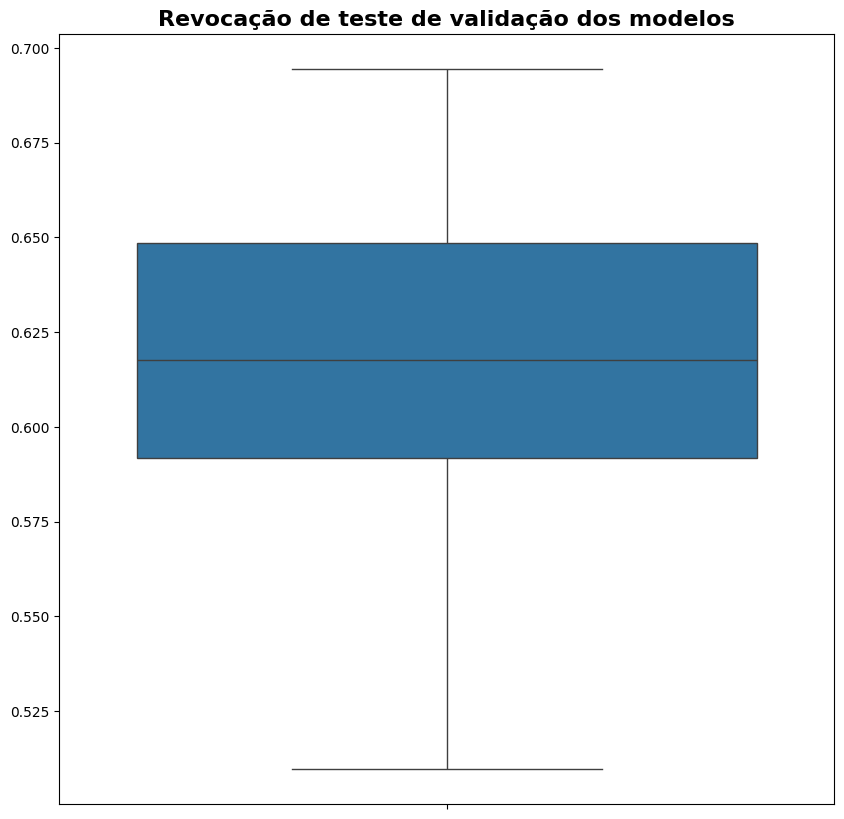

In [16]:
plt.figure(figsize = (10,10))
sns.boxplot(NB["test_recall_macro"])
plt.title("Revocação de teste de validação dos modelos", fontsize = 16, weight = "bold");

In [17]:
NB = NB["estimator"]

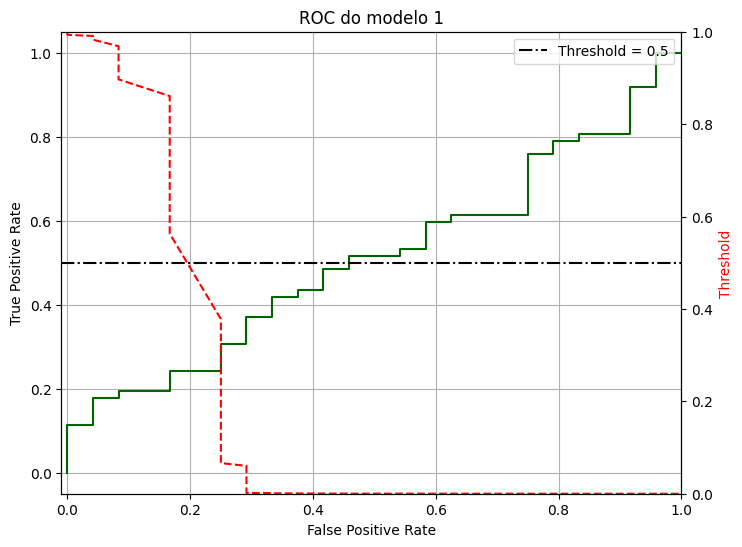

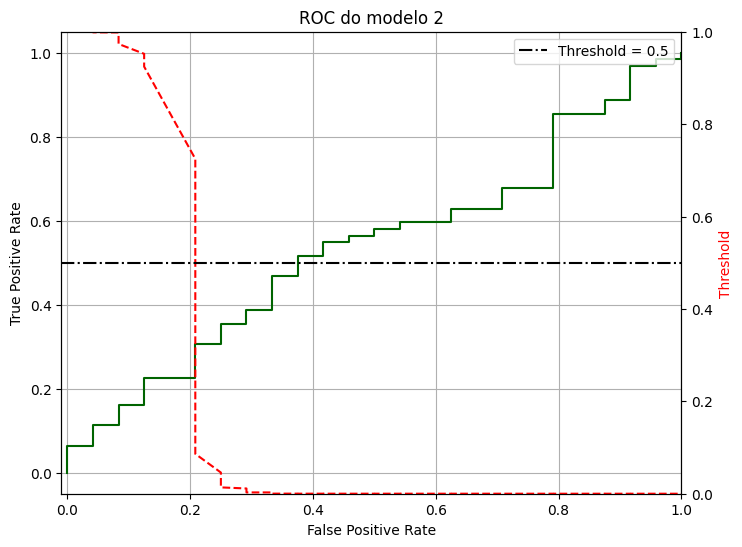

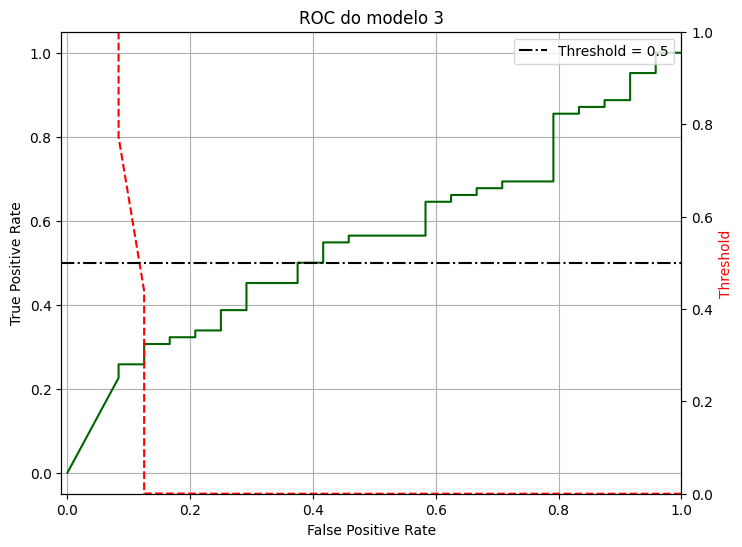

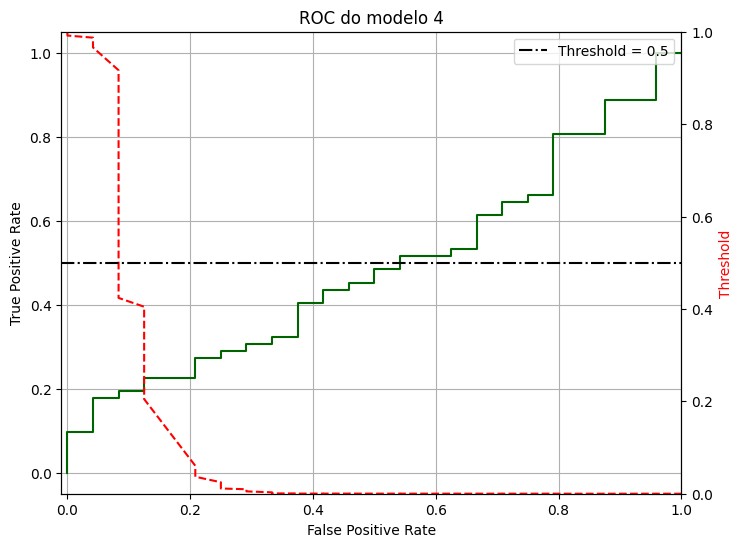

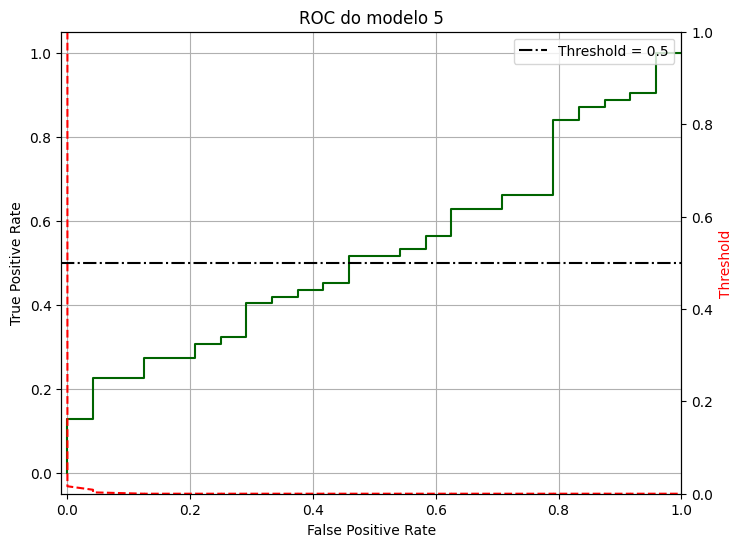

In [18]:
for i in range(5):
    y_pred_proba = NB[i].predict_proba(X_test)[::,1]
    fpr, tpr, sarrafo = roc_curve(y_test,  y_pred_proba)
    sarrafo = sarrafo[fpr <= 1]

    #create ROC curve
    plt.figure(figsize = (8,6))
    plt.plot(fpr,tpr, lw = 1.5, color = "darkgreen")
    plt.grid()
    plt.title(f"ROC do modelo {i + 1}")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, sarrafo, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([0,1])
    ax2.set_xlim([-0.01,1])
    ax2.axhline(y = 0.5, lw = 1.5, color = "black", ls = "-.", label = "Threshold = 0.5")
    plt.legend()

    plt.show()

In [19]:
for i in range(5):
    scores = [accuracy_score(y_test, NB[i].predict(X_test)),
                             balanced_accuracy_score(y_test, NB[i].predict(X_test)),
                             f1_score(y_test, NB[i].predict(X_test), average = "macro"),
                             precision_score(y_test, NB[i].predict(X_test)),
                             roc_auc_score(y_test, NB[i].predict(X_test))]
    scores_names = ["Acurácia", "Acurácia_balanceada", "F1_macro", "Precisão", "ROC"]

    print("Modelo", i + 1)
    print(pd.DataFrame([scores], columns = scores_names))

Modelo 1
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0  0.395349             0.516801  0.394038      0.75  0.516801
Modelo 2
   Acurácia  Acurácia_balanceada  F1_macro  Precisão      ROC
0  0.418605              0.53293   0.41829  0.772727  0.53293
Modelo 3
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0   0.44186             0.587366   0.43913  0.888889  0.587366
Modelo 4
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0  0.383721             0.547043  0.373471  0.846154  0.547043
Modelo 5
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0  0.348837             0.548387  0.319005       1.0  0.548387


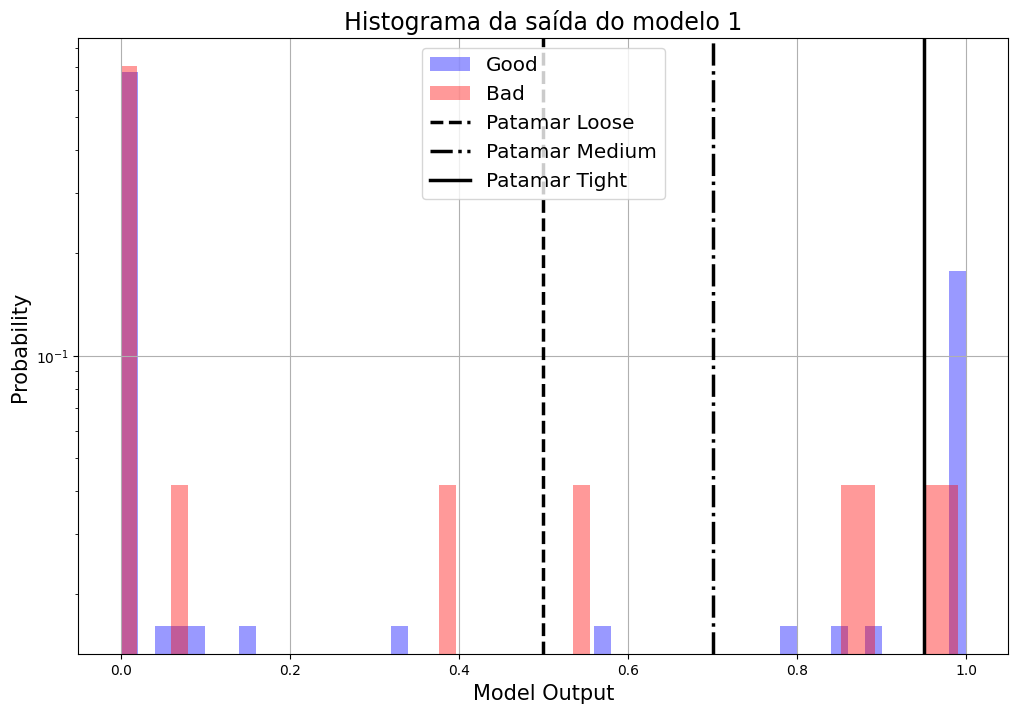

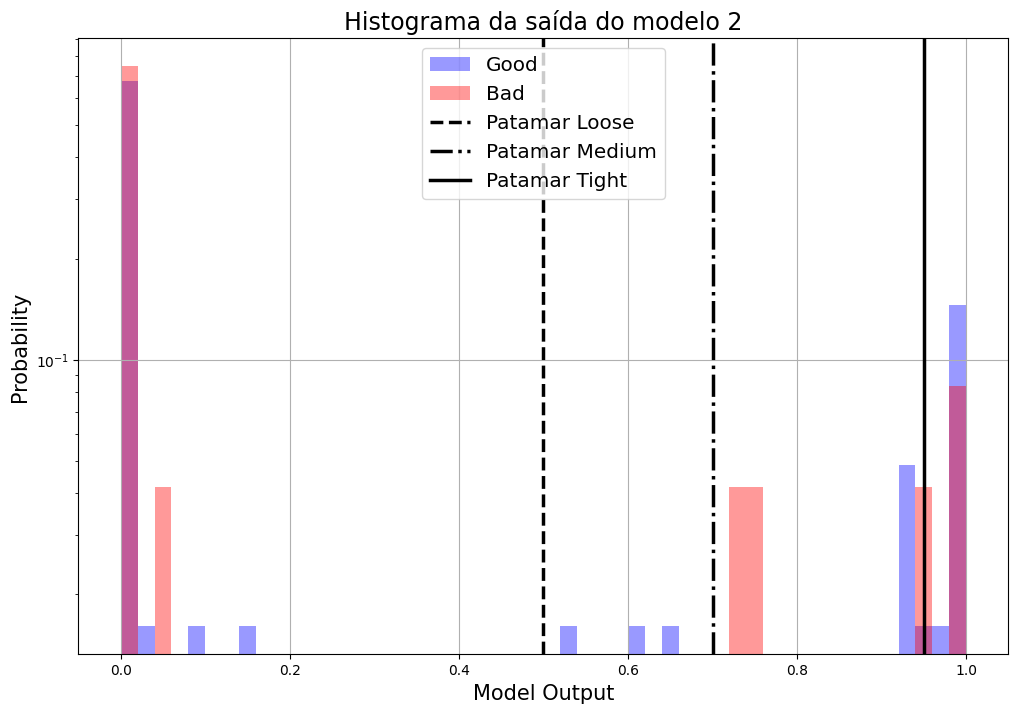

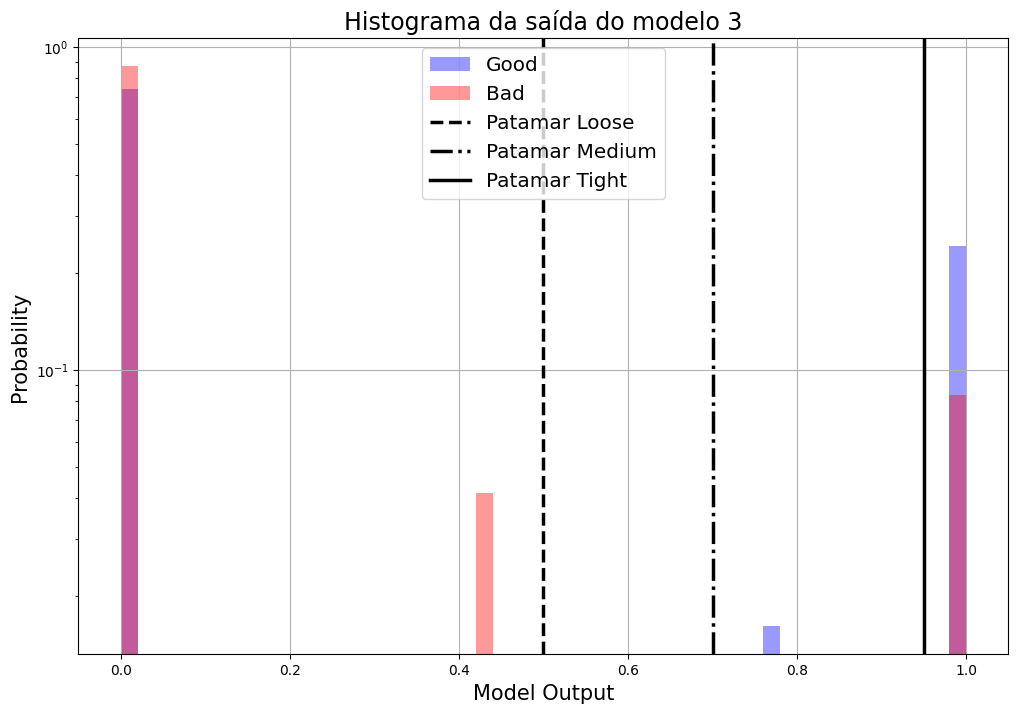

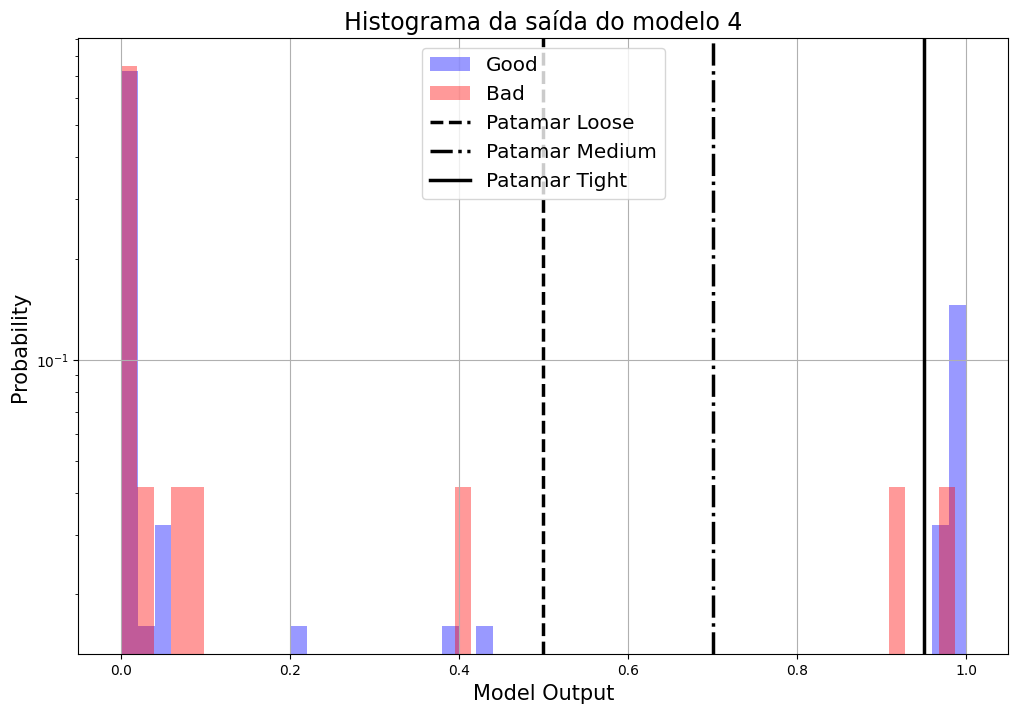

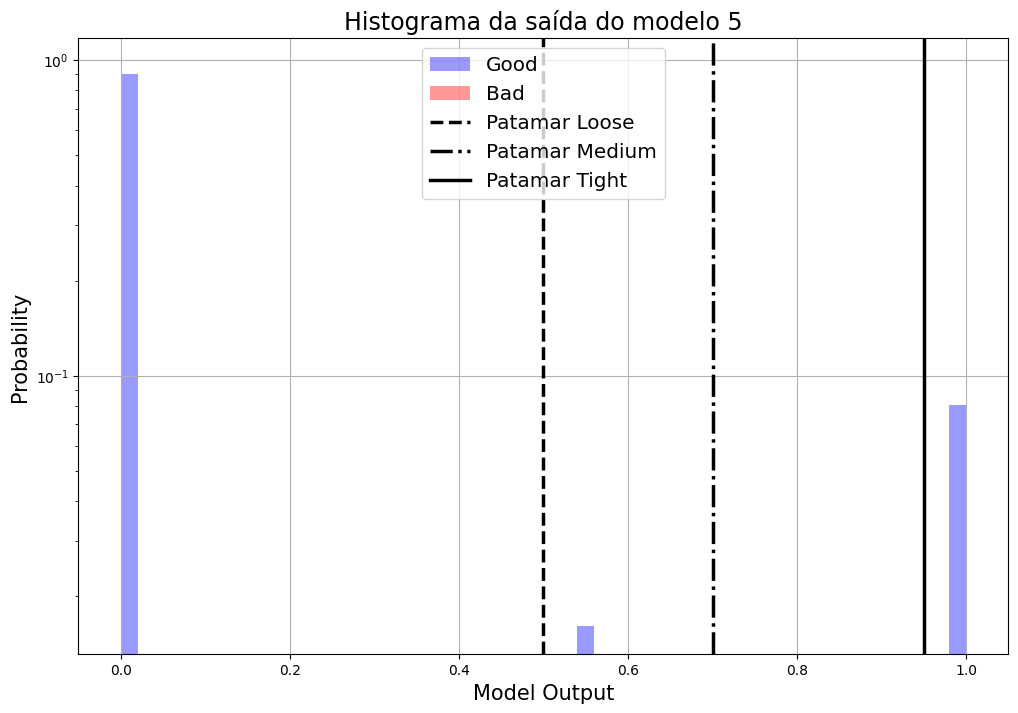

In [20]:
predict_model_cols = X_test.columns

for model_idx in range(5):
    # Separa os valores de teste
    if "probabilidade_model_%i" %(model_idx) not in X_test.columns:
        X_test["probabilidade_model_%i" %(model_idx)] = NB[model_idx].predict_proba(X_test[predict_model_cols])[:,1]

    #Figura
    plt.figure(figsize = (12,8))
    # weights for hist 1
    weights_h1 = (np.ones_like(X_test.loc[y_test == 1, "probabilidade_model_%i" %(model_idx)].values)/\
                  len(X_test.loc[y_test == 1, "probabilidade_model_%i" %(model_idx)]))
    # weights for hist 2
    weights_h2 = (np.ones_like(X_test.loc[y_test != 1, "probabilidade_model_%i" %(model_idx)].values)/\
                  len(X_test.loc[y_test != 1, "probabilidade_model_%i" %(model_idx)]))

    plt.hist(X_test.loc[y_test == 1, "probabilidade_model_%i" %(model_idx)],
             label='Good', weights=weights_h1,
             color='blue', bins=50, histtype='stepfilled', lw=1.5, alpha=.4)
    plt.hist(X_test.loc[y_test != 1, "probabilidade_model_%i" %(model_idx)],
             label='Bad', weights=weights_h2,
             color='red', bins=50, histtype='stepfilled', lw=1.5, alpha=.4)
    #sns.histplot(x = x_test["probabilidade de pagar"],
    #             hue = y_test)
    plt.ylabel('Probability', fontsize=15)
    plt.xlabel('Model Output', fontsize=15)
    plt.grid()
    plt.title(f"Histograma da saída do modelo {model_idx+1}", fontsize=17)
    plt.axvline(x=.5, color='black', lw=2.5, ls='--', label='Patamar Loose')
    plt.axvline(x=.7, color='black', lw=2.5, ls='-.', label='Patamar Medium')
    plt.axvline(x=.95, color='black', lw=2.5, ls='-', label='Patamar Tight')
    plt.legend(loc='upper center', fontsize='x-large')
    plt.yscale('log')
    plt.show()

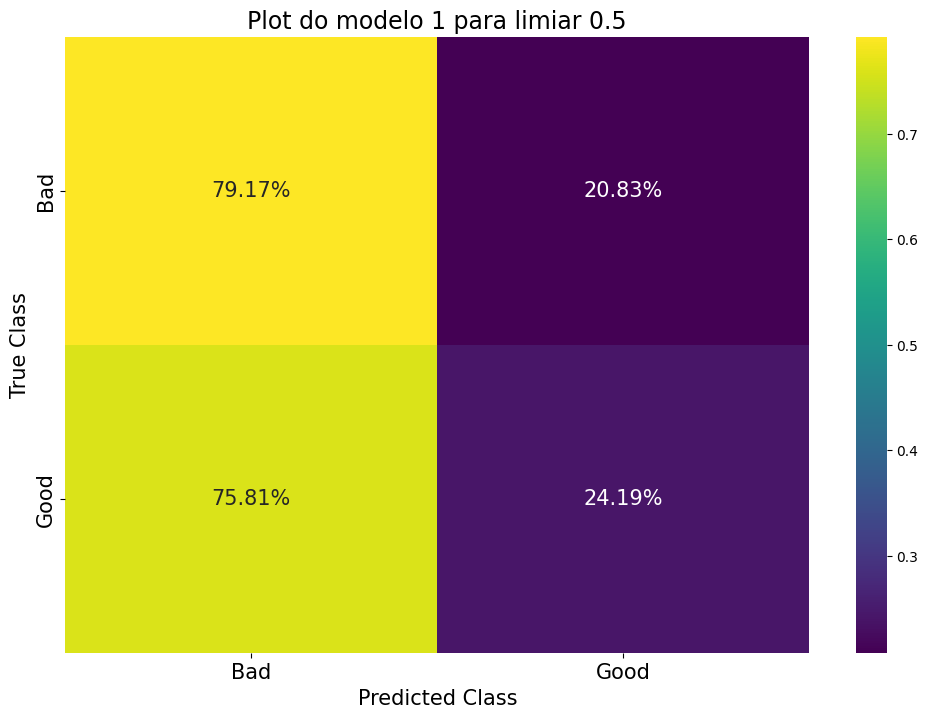

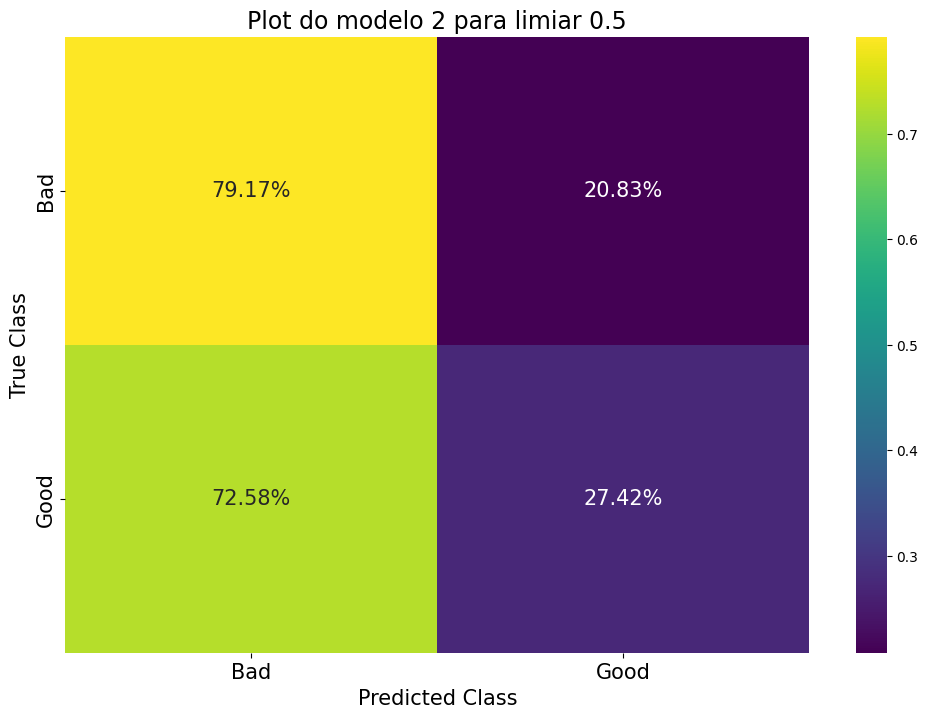

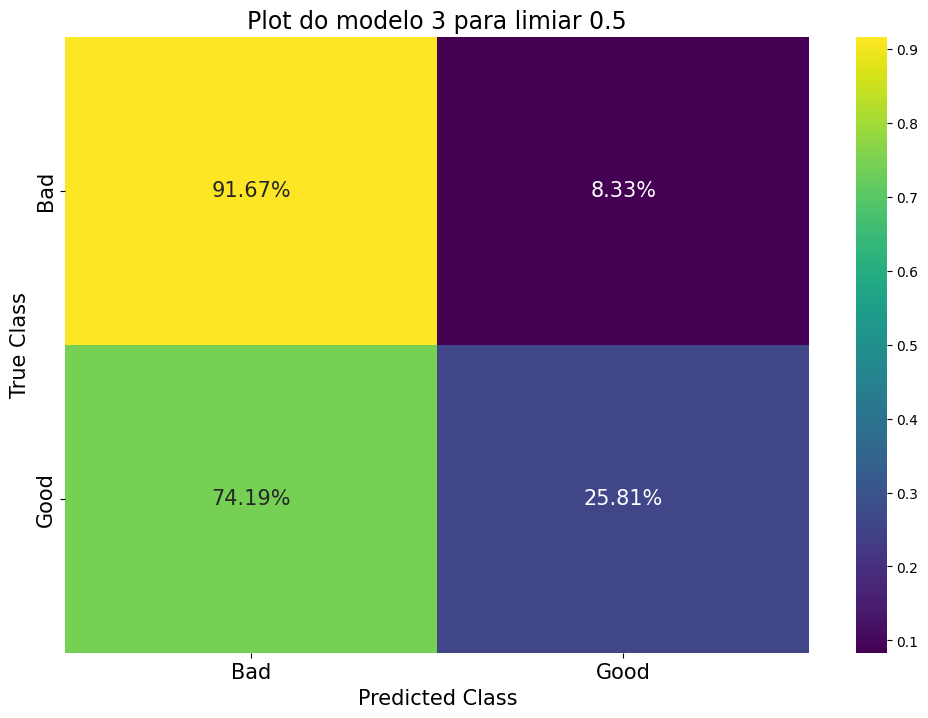

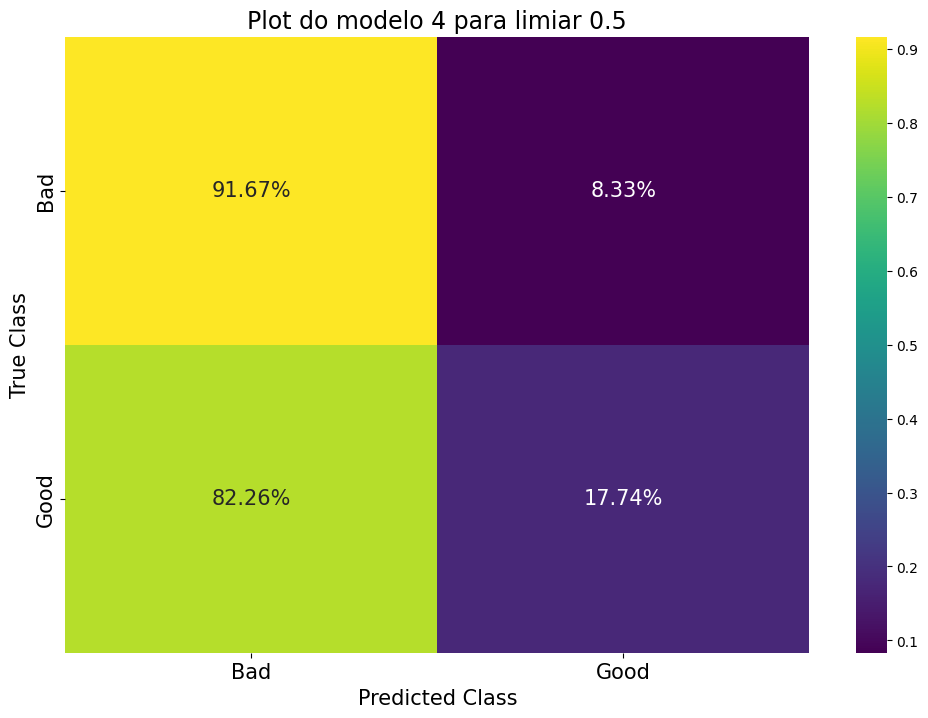

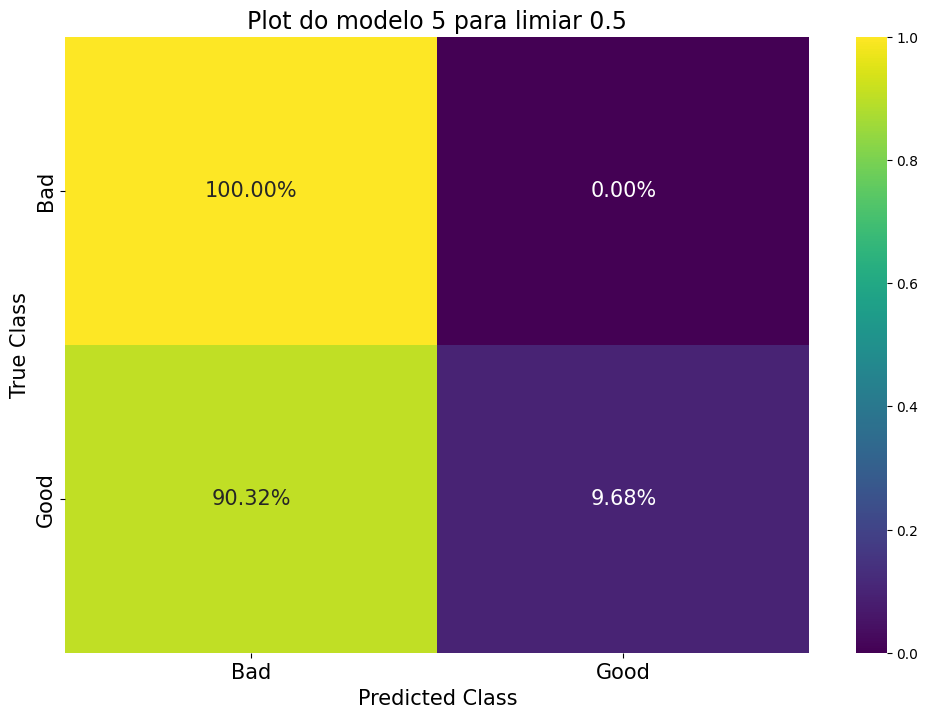

In [21]:
for i in range(5):
    plt.figure(figsize = (12,8))
    matriz = confusion_matrix(y_test, NB[i].predict(X_test[predict_model_cols]), normalize = "true")
    ax = sns.heatmap(matriz, cmap = "viridis", annot = True, annot_kws={"fontsize":15}, fmt=".2%")
    ax.set_title(f"Plot do modelo {i+1} para limiar 0.5", fontsize=17)
    ax.set_ylabel("True Class", fontsize=15)
    ax.set_xlabel("Predicted Class", fontsize=15)
    ax.set_xticklabels(["Bad", "Good"], fontsize=15)
    ax.set_yticklabels(["Bad", "Good"], fontsize=15)
    plt.show()
    "/n"

# LGBM Classifier

In [22]:
# # Definindo os parâmetros para o GridSearchCV
# param_grid = {
#     'n_estimators': [10, 50, 100, 200],
#     'min_child_samples': [5, 10, 20],
#     'num_leaves': [5, 10, 20, 31],
#     'max_depth': [3, 4, 5, -1],
#     'learning_rate': [0.1, 0.01, 0.001]
# }

# # Configurando o cross-validation
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=451)

# # Configurando o GridSearchCV
# grid_search = GridSearchCV(
#     estimator=LGBMClassifier(class_weight="balanced", random_state=451),
#     param_grid=param_grid,
#     scoring="f1_macro",  # Usando f1_macro como métrica principal, pode ajustar conforme necessidade
#     cv=skf,
#     verbose=2,
#     n_jobs=-1  # Utiliza todos os núcleos disponíveis para acelerar a busca
# )

# # Treinando o GridSearchCV
# grid_search.fit(X_train, y_train)

# # Exibindo os melhores parâmetros e o melhor score
# print("Melhores parâmetros encontrados:", grid_search.best_params_)
# print("Melhor score F1_macro encontrado:", grid_search.best_score_)


In [100]:
skf = StratifiedKFold(n_splits = 5, shuffle = True)

#'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 10, 'n_estimators': 100, 'num_leaves': 10

LGBM = cross_validate(estimator=LGBMClassifier(class_weight="balanced",
                                                  n_estimators=75,
                                                  min_child_samples=6,
                                                  num_leaves=6,
                                                  max_depth=4,
                                                  #learning_rate=0.1,
                                                  random_state=451),
                         cv=skf,
                         scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro", "roc_auc"],
                         return_estimator=True,
                         return_train_score=True,
                         verbose=2,
                         X=X_train,
                         y=y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 146, number of negative: 58
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 88
[LightGBM] [Info] Number of data points in the train set: 204, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[CV] END .................................................... total time=   0.0s
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 146, number of negative: 58
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_row_wise=true` to rem

In [101]:
cv_df = pd.DataFrame(LGBM)
cv_df

,fit_time,score_time,estimator,test_accuracy,train_accuracy,test_precision_macro,train_precision_macro,test_recall_macro,train_recall_macro,test_f1_macro,train_f1_macro,test_roc_auc,train_roc_auc
0,0.019855,0.016206,"LGBMClassifier(class_weight='balanced', max_de...",0.745098,0.848039,0.725155,0.818929,0.779923,0.878248,0.724324,0.832018,0.886100,0.946327
1,0.020492,0.016243,"LGBMClassifier(class_weight='balanced', max_de...",0.588235,0.862745,0.621473,0.837209,0.649614,0.904110,0.577848,0.849747,0.720077,0.962329
2,0.018835,0.014088,"LGBMClassifier(class_weight='balanced', max_de...",0.705882,0.813725,0.647059,0.792398,0.664093,0.854275,0.652431,0.798545,0.763514,0.967289
3,0.019510,0.015251,"LGBMClassifier(class_weight='balanced', max_de...",0.745098,0.877451,0.690244,0.845968,0.644444,0.909595,0.655584,0.862634,0.740741,0.966165
4,0.021558,0.014699,"LGBMClassifier(class_weight='balanced', max_de...",0.549020,0.877451,0.537037,0.844628,0.544444,0.904225,0.522589,0.861620,0.589815,0.966165


In [102]:
teste = ['test_accuracy', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro', 'test_roc_auc']
for icol in teste:
    print('%s -> mean: %1.2f +- %1.2f' %(icol, cv_df[icol].mean(), cv_df[icol].std()))

test_accuracy -> mean: 0.67 +- 0.09
test_precision_macro -> mean: 0.64 +- 0.07
test_recall_macro -> mean: 0.66 +- 0.08
test_f1_macro -> mean: 0.63 +- 0.08
test_roc_auc -> mean: 0.74 +- 0.11


Média de acurácia de treino dos modelos: 0.8558823529411764 
 Desvio padrão de acurácia de treino dos modelos: 0.02373278124884354
Média de acurácia de teste dos modelos: 0.6666666666666667 
 Desvio padrão de acurácia de teste dos modelos: 0.0822595175035413


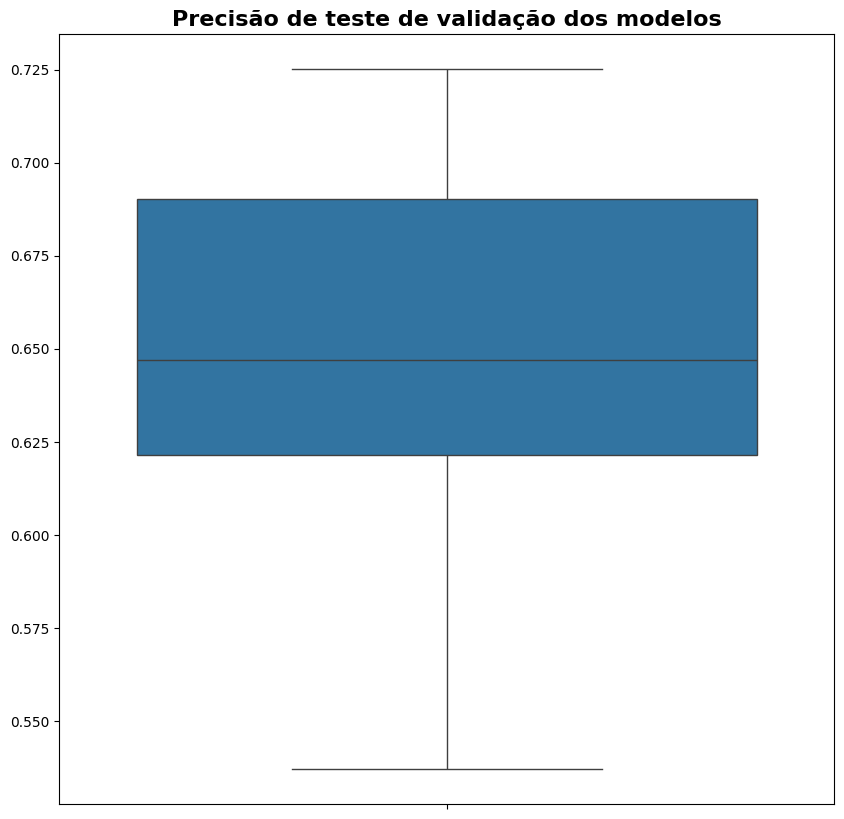

In [103]:
print("Média de acurácia de treino dos modelos:", LGBM["train_accuracy"].mean(), "\n", "Desvio padrão de acurácia de treino dos modelos:", LGBM["train_accuracy"].std())
print("Média de acurácia de teste dos modelos:", LGBM["test_accuracy"].mean(), "\n", "Desvio padrão de acurácia de teste dos modelos:", LGBM["test_accuracy"].std())

plt.figure(figsize = (10,10))
sns.boxplot(LGBM["test_precision_macro"])
plt.title("Precisão de teste de validação dos modelos", fontsize = 16, weight = "bold");


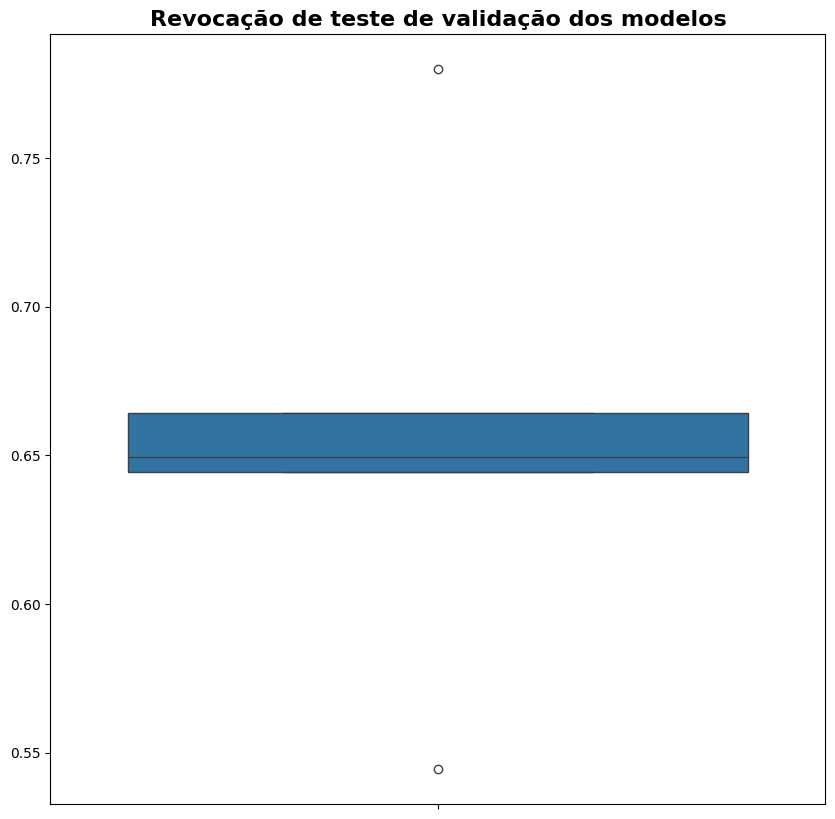

In [104]:
plt.figure(figsize = (10,10))
sns.boxplot(LGBM["test_recall_macro"])
plt.title("Revocação de teste de validação dos modelos", fontsize = 16, weight = "bold");

In [105]:
LGBM = LGBM["estimator"]
LGBM

[LGBMClassifier(class_weight='balanced', max_depth=4, min_child_samples=6,
                n_estimators=75, num_leaves=6, random_state=451),
 LGBMClassifier(class_weight='balanced', max_depth=4, min_child_samples=6,
                n_estimators=75, num_leaves=6, random_state=451),
 LGBMClassifier(class_weight='balanced', max_depth=4, min_child_samples=6,
                n_estimators=75, num_leaves=6, random_state=451),
 LGBMClassifier(class_weight='balanced', max_depth=4, min_child_samples=6,
                n_estimators=75, num_leaves=6, random_state=451),
 LGBMClassifier(class_weight='balanced', max_depth=4, min_child_samples=6,
                n_estimators=75, num_leaves=6, random_state=451)]

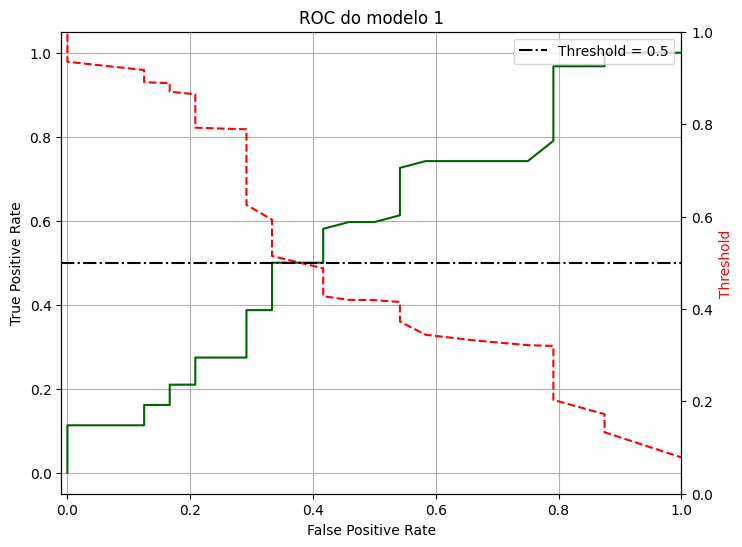

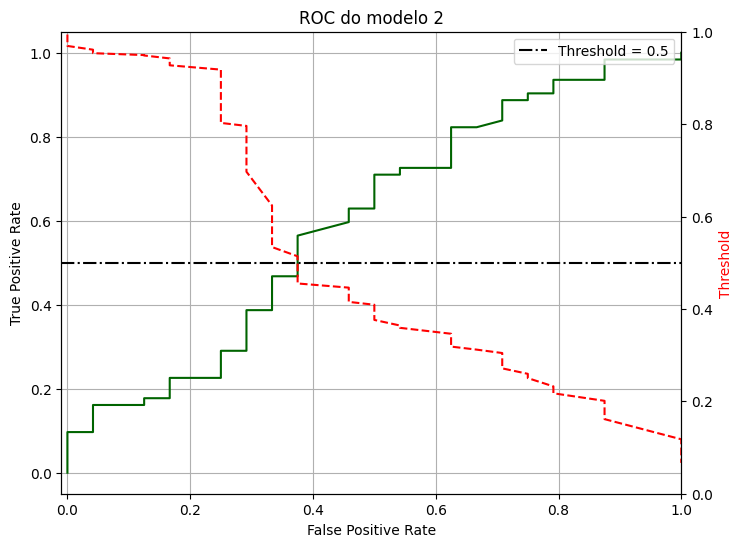

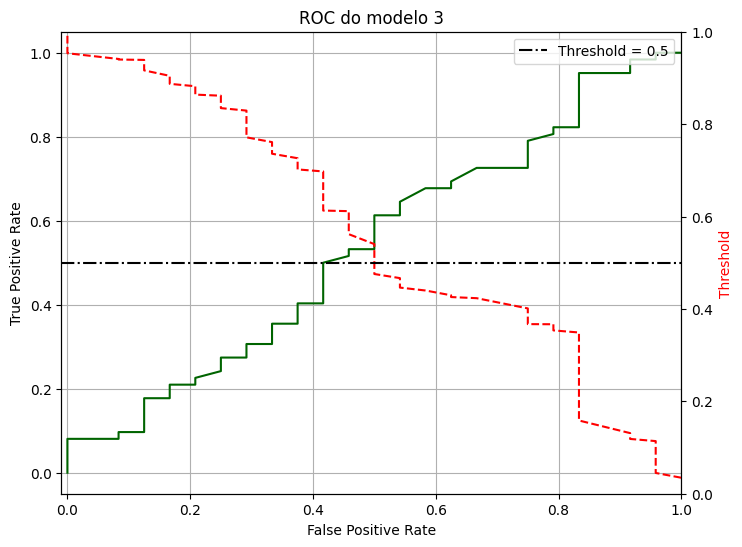

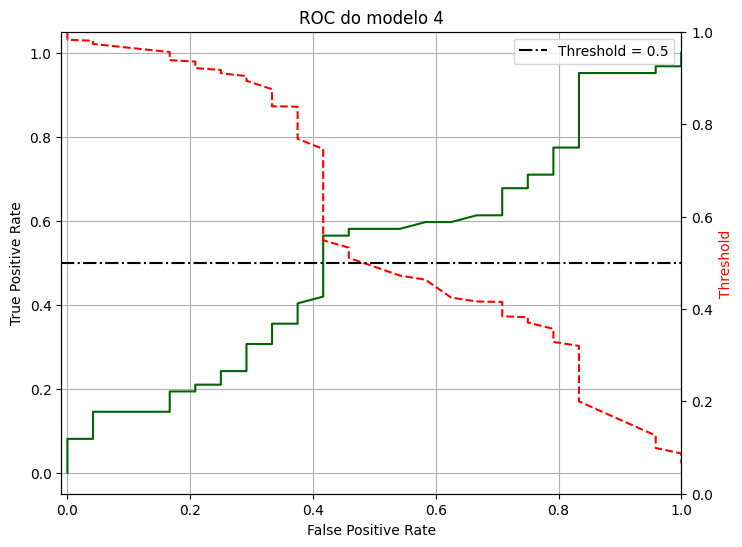

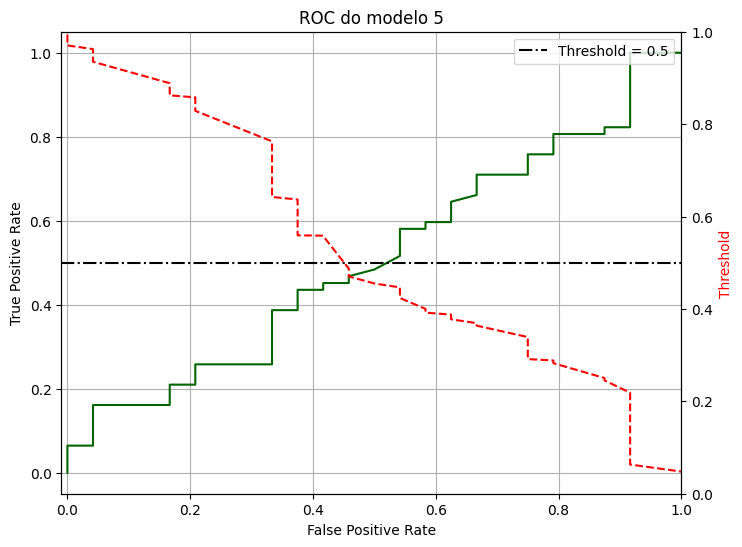

In [106]:
X_test = X_test[X_train.columns]
for i in range(5):
    y_pred_proba = LGBM[i].predict_proba(X_test)[::,1]
    fpr, tpr, sarrafo = roc_curve(y_test,  y_pred_proba)
    sarrafo = sarrafo[fpr <= 1]

    #create ROC curve
    plt.figure(figsize = (8,6))
    plt.plot(fpr,tpr, lw = 1.5, color = "darkgreen")
    plt.grid()
    plt.title(f"ROC do modelo {i + 1}")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, sarrafo, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([0,1])
    ax2.set_xlim([-0.01,1])
    ax2.axhline(y = 0.5, lw = 1.5, color = "black", ls = "-.", label = "Threshold = 0.5")
    plt.legend()

    plt.show()

In [107]:
for i in range(5):
    scores = [accuracy_score(y_test, LGBM[i].predict(X_test)),
                             balanced_accuracy_score(y_test, LGBM[i].predict(X_test)),
                             f1_score(y_test, LGBM[i].predict(X_test), average = "macro"),
                             precision_score(y_test, LGBM[i].predict(X_test)),
                             roc_auc_score(y_test, LGBM[i].predict(X_test))]
    scores_names = ["Acurácia", "Acurácia_balanceada", "F1_macro", "Precisão", "ROC"]

    print("Modelo", i + 1)
    print(pd.DataFrame([scores], columns = scores_names))

Modelo 1
   Acurácia  Acurácia_balanceada  F1_macro  Precisão     ROC
0  0.534884               0.5625  0.518207     0.775  0.5625
Modelo 2
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0  0.511628             0.546371  0.498333  0.763158  0.546371
Modelo 3
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0  0.546512             0.532258  0.511577  0.744681  0.532258
Modelo 4
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0  0.569767             0.561156  0.536624  0.765957  0.561156
Modelo 5
   Acurácia  Acurácia_balanceada  F1_macro  Precisão       ROC
0  0.488372             0.517473  0.474444  0.736842  0.517473


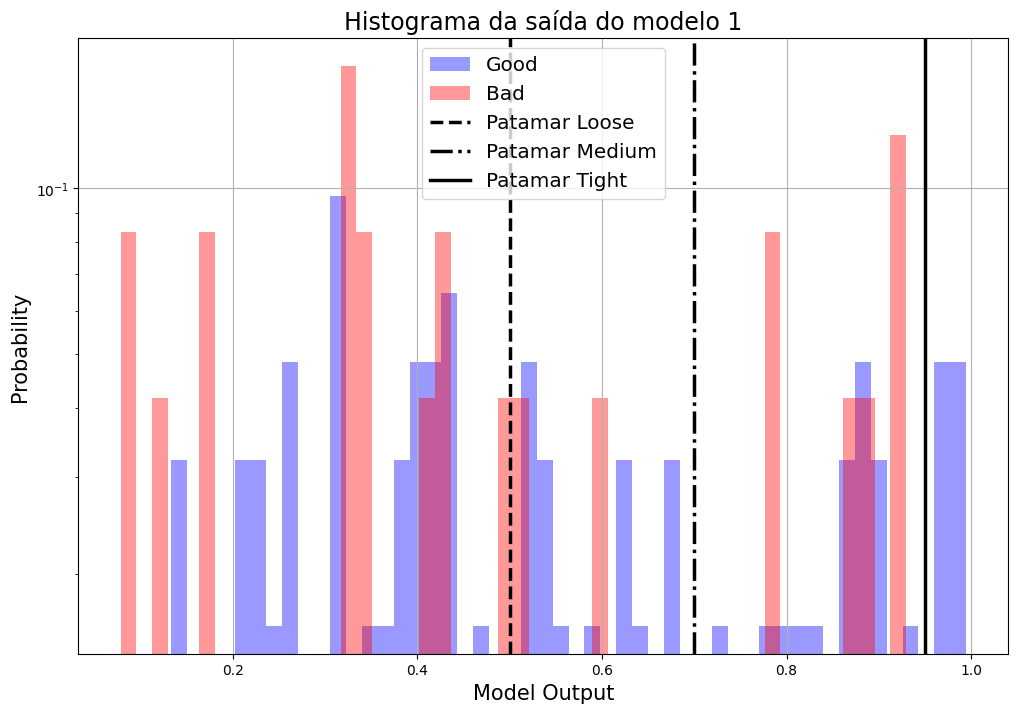

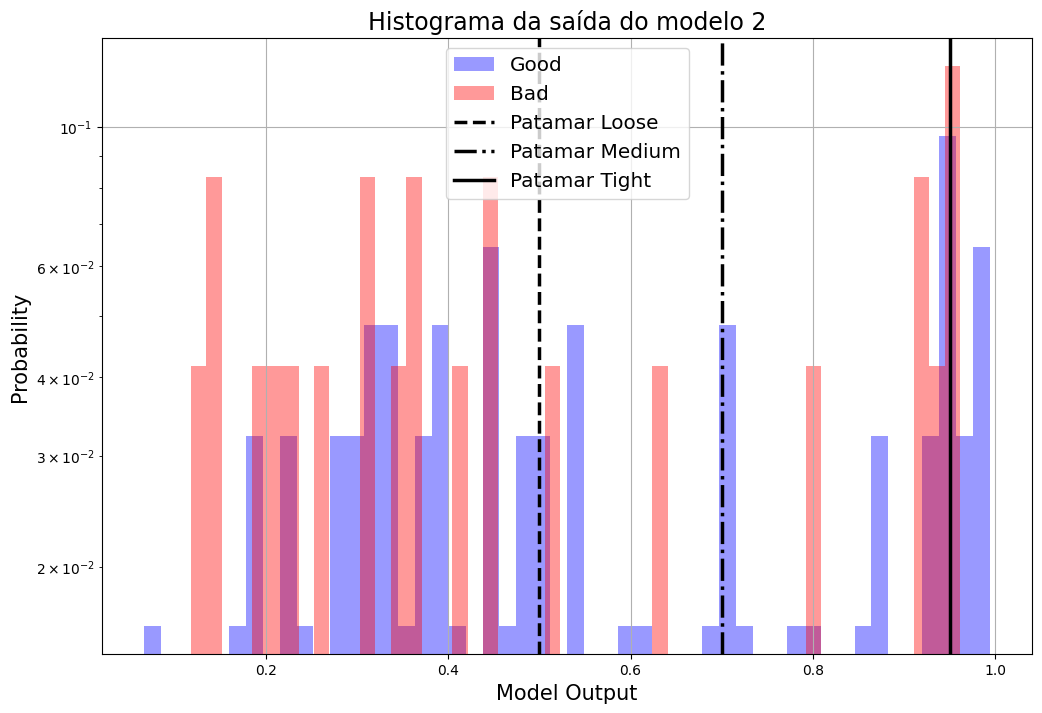

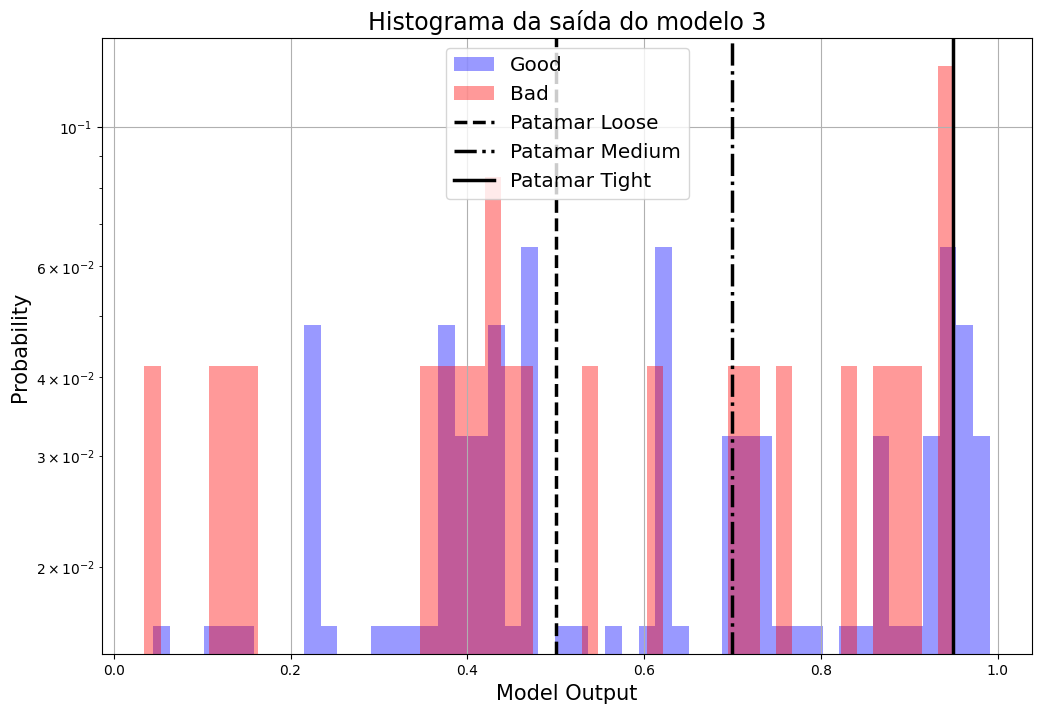

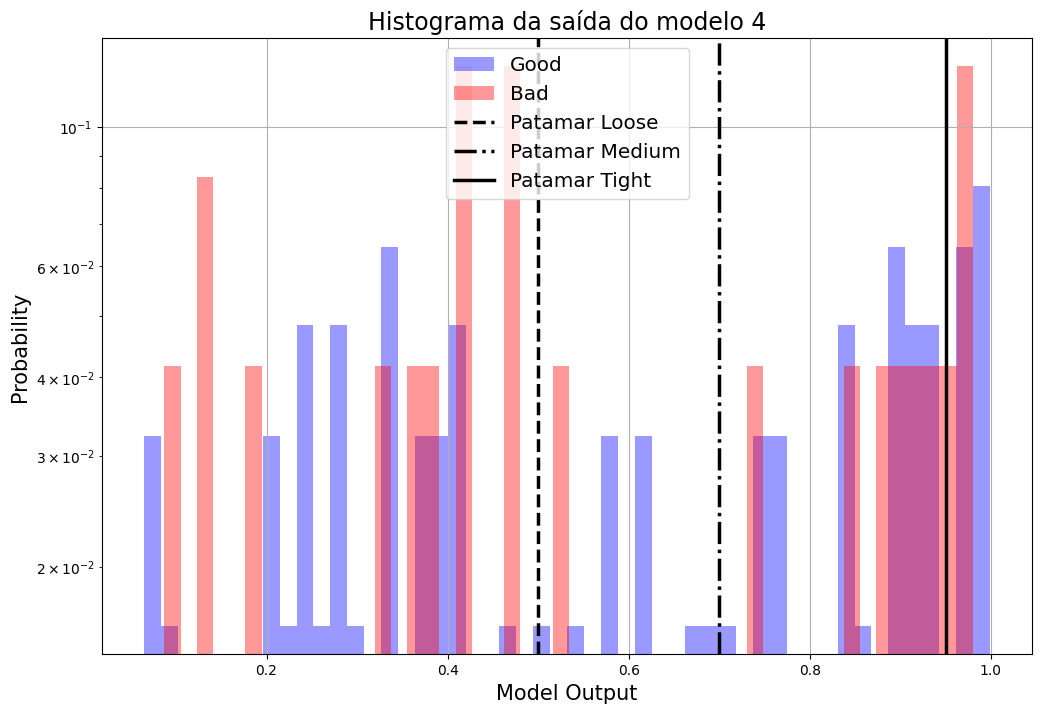

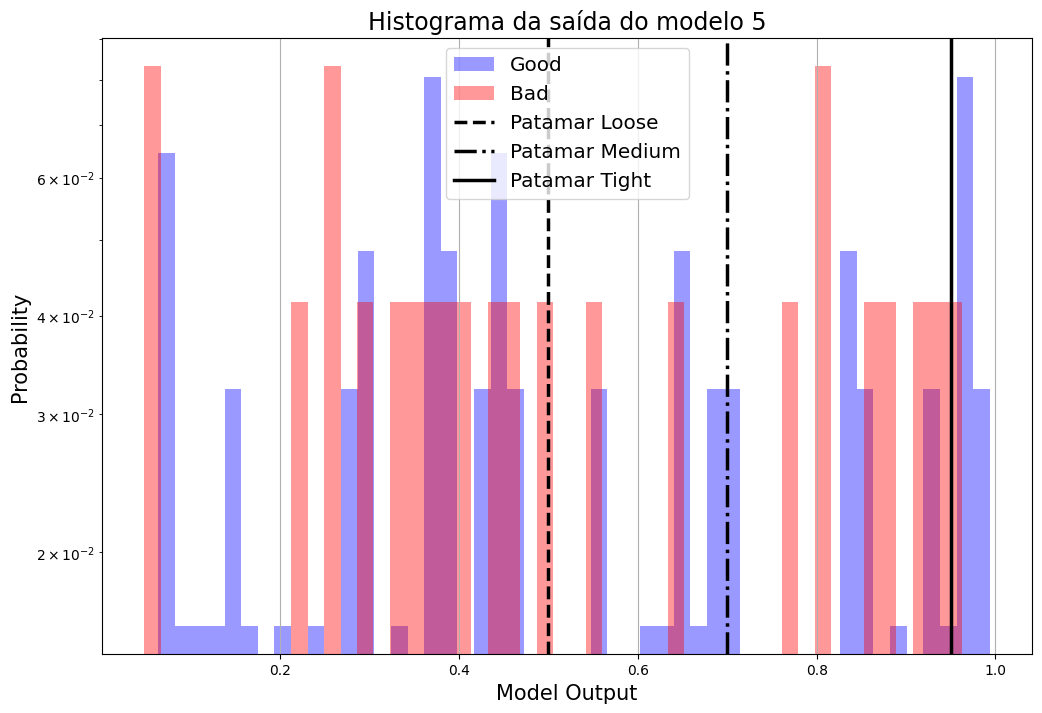

In [108]:
predict_model_cols = X_test.columns

for model_idx in range(5):
    # Separa os valores de teste
    if "probabilidade_model_%i" %(model_idx) not in X_test.columns:
        X_test["probabilidade_model_%i" %(model_idx)] = LGBM[model_idx].predict_proba(X_test[predict_model_cols])[:,1]

    #Figura
    plt.figure(figsize = (12,8))
    # weights for hist 1
    weights_h1 = (np.ones_like(X_test.loc[y_test == 1, "probabilidade_model_%i" %(model_idx)].values)/\
                  len(X_test.loc[y_test == 1, "probabilidade_model_%i" %(model_idx)]))
    # weights for hist 2
    weights_h2 = (np.ones_like(X_test.loc[y_test != 1, "probabilidade_model_%i" %(model_idx)].values)/\
                  len(X_test.loc[y_test != 1, "probabilidade_model_%i" %(model_idx)]))

    plt.hist(X_test.loc[y_test == 1, "probabilidade_model_%i" %(model_idx)],
             label='Good', weights=weights_h1,
             color='blue', bins=50, histtype='stepfilled', lw=1.5, alpha=.4)
    plt.hist(X_test.loc[y_test != 1, "probabilidade_model_%i" %(model_idx)],
             label='Bad', weights=weights_h2,
             color='red', bins=50, histtype='stepfilled', lw=1.5, alpha=.4)
    #sns.histplot(x = x_test["probabilidade de pagar"],
    #             hue = y_test)
    plt.ylabel('Probability', fontsize=15)
    plt.xlabel('Model Output', fontsize=15)
    plt.grid()
    plt.title(f"Histograma da saída do modelo {model_idx+1}", fontsize=17)
    plt.axvline(x=.5, color='black', lw=2.5, ls='--', label='Patamar Loose')
    plt.axvline(x=.7, color='black', lw=2.5, ls='-.', label='Patamar Medium')
    plt.axvline(x=.95, color='black', lw=2.5, ls='-', label='Patamar Tight')
    plt.legend(loc='upper center', fontsize='x-large')
    plt.yscale('log')
    plt.show()

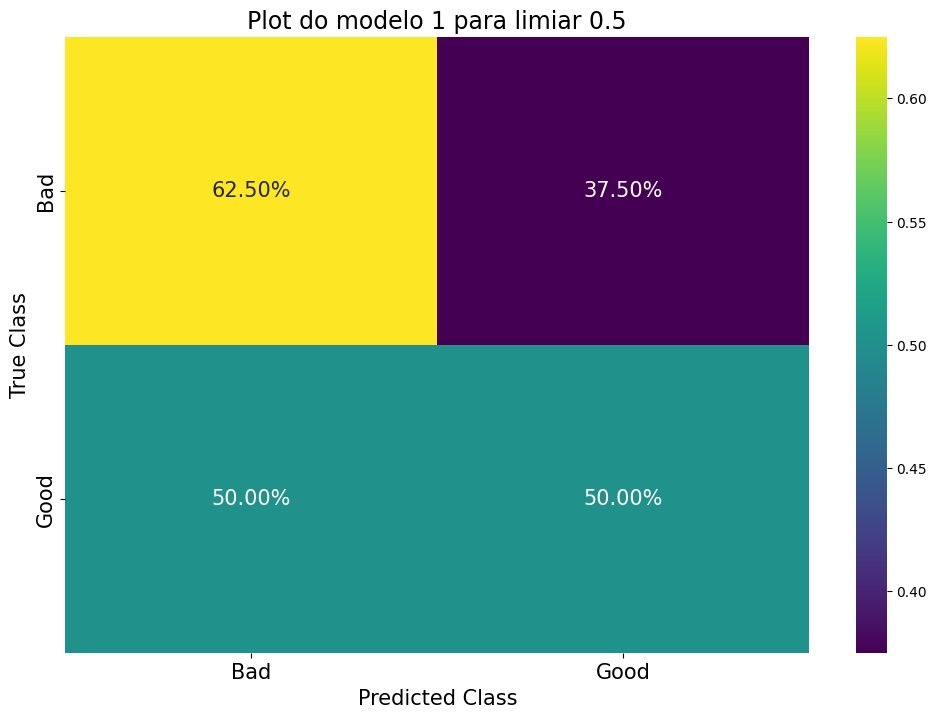

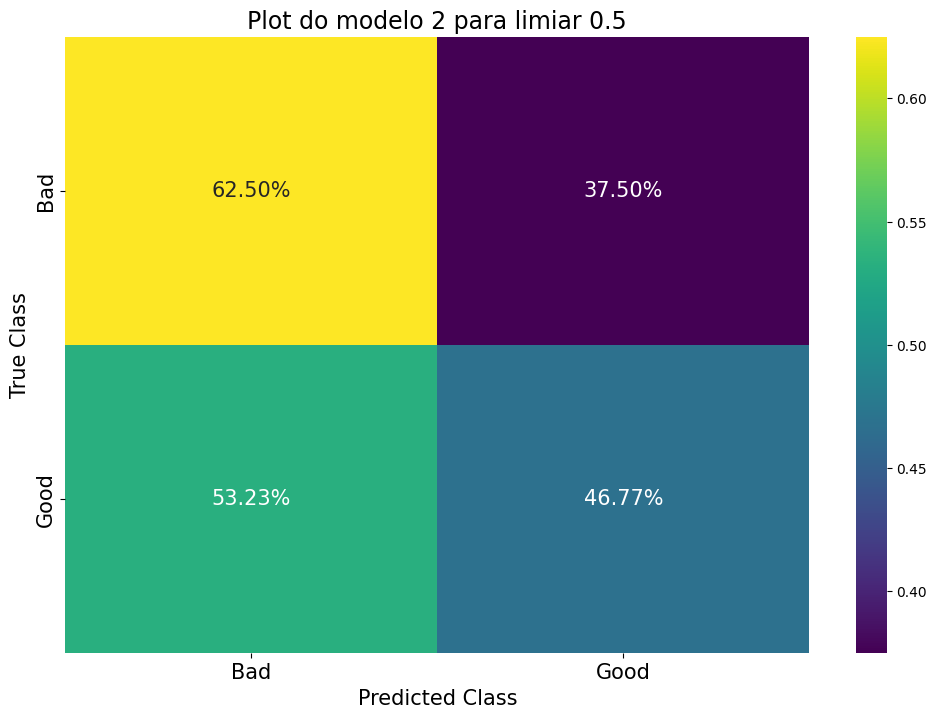

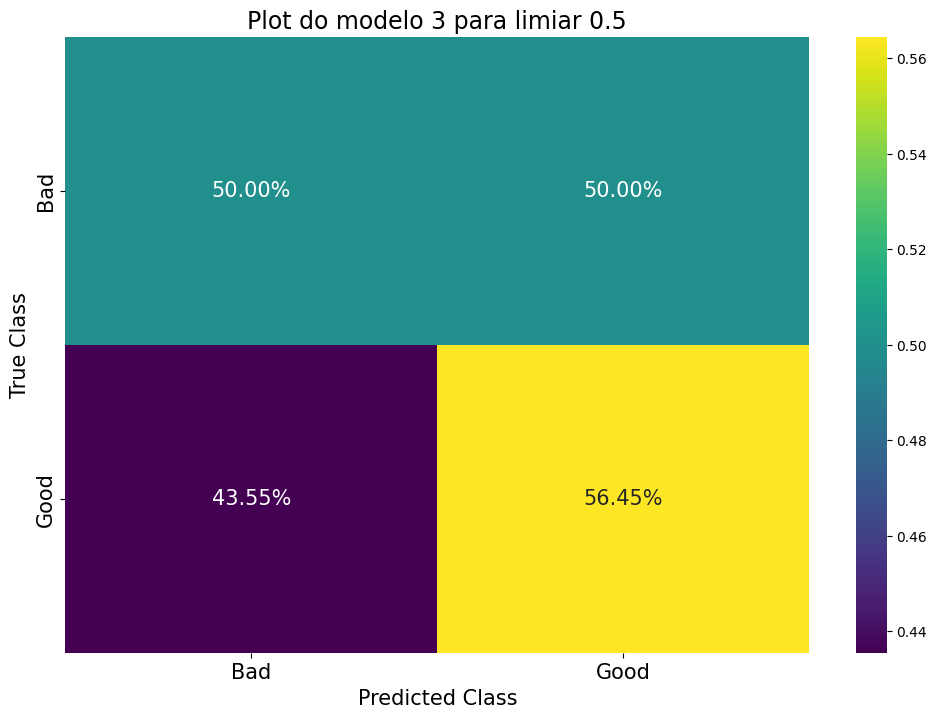

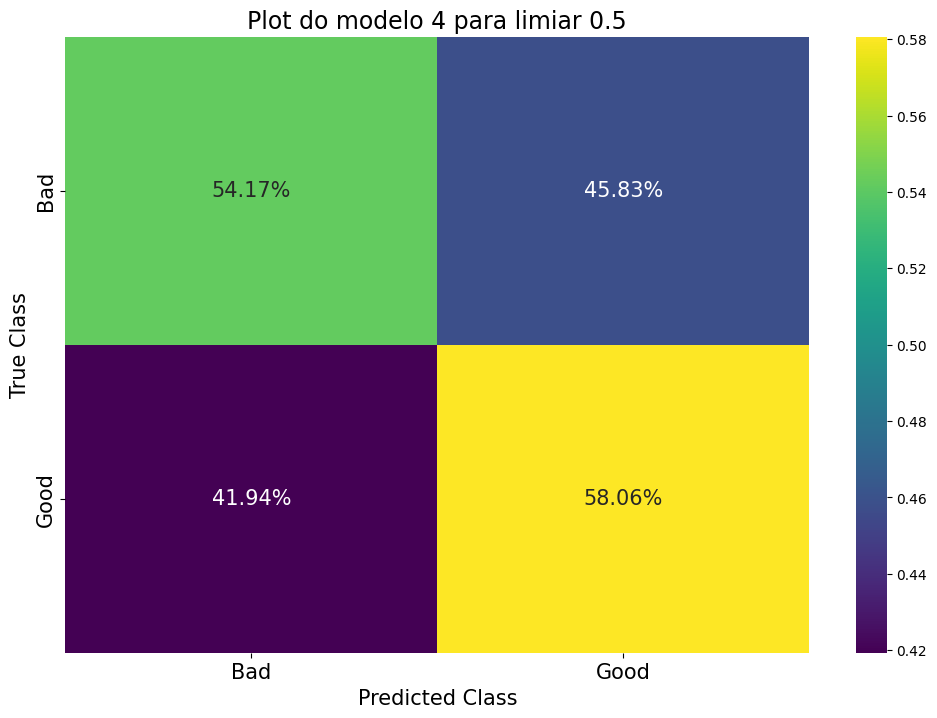

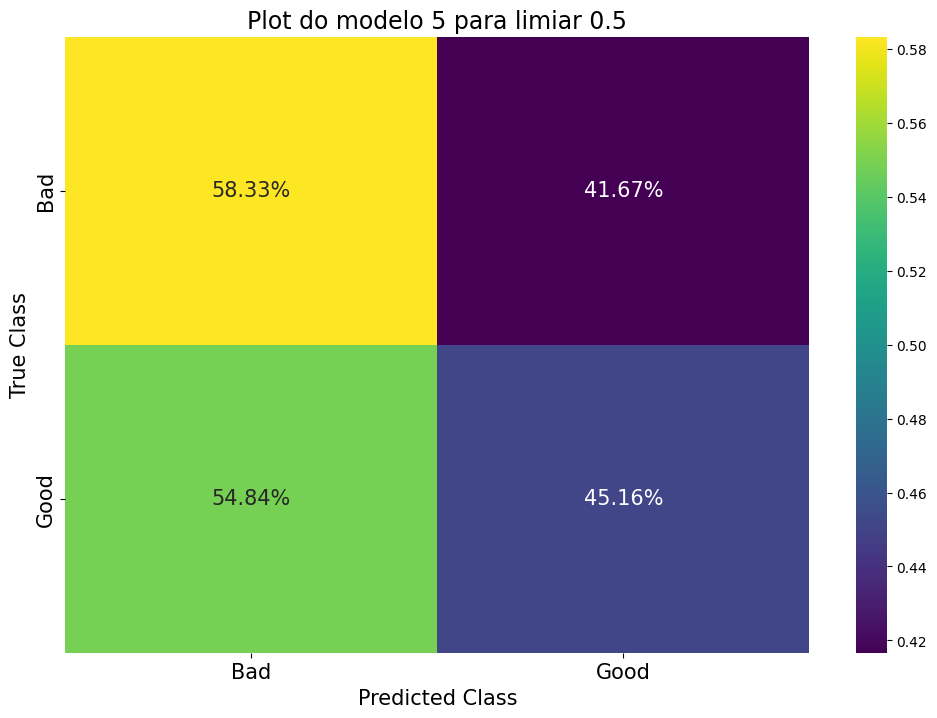

In [109]:
for i in range(5):
    plt.figure(figsize = (12,8))
    matriz = confusion_matrix(y_test, LGBM[i].predict(X_test[predict_model_cols]), normalize = "true")
    ax = sns.heatmap(matriz, cmap = "viridis", annot = True, annot_kws={"fontsize":15}, fmt=".2%")
    ax.set_title(f"Plot do modelo {i+1} para limiar 0.5", fontsize=17)
    ax.set_ylabel("True Class", fontsize=15)
    ax.set_xlabel("Predicted Class", fontsize=15)
    ax.set_xticklabels(["Bad", "Good"], fontsize=15)
    ax.set_yticklabels(["Bad", "Good"], fontsize=15)
    plt.show()
    "/n"

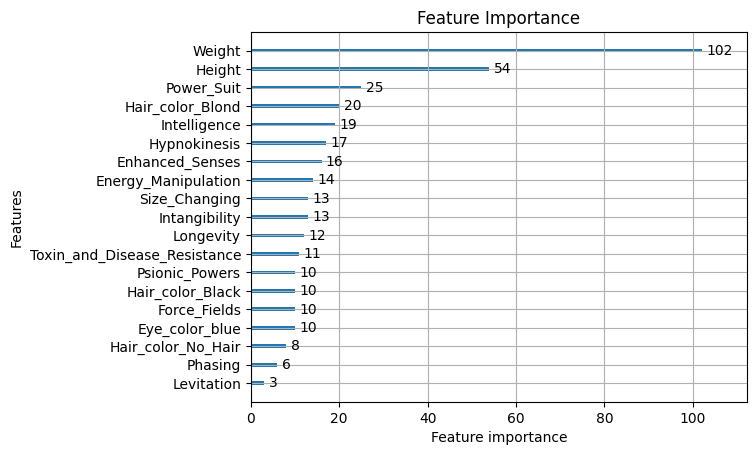

In [110]:
import lightgbm as lgb
lgb.plot_importance(LGBM[2], max_num_features=30)  # max_num_features define o número de features exibidas
plt.title("Feature Importance")
plt.show()